# PHAS0102 HPC Project - Stage 1

by Fahad Chohan <br>
Student Number: 15019455 <br>
Date - 08/03/2019

## Introduction

The aim of this project was to use iterative solvers to solve the Poisson equation below for $(x, y)\in [0, 1]\times [0, 1]$ with boundary conditions $u(x, y) = 0$. This was done using the linear algebra scipy package from which the gmres, bicgstab, minres and cg iterative solvers were used.

$$-\nabla \cdot \left(\sigma(x, y)\nabla\right)u(x, y) = f(x, y)$$

From this Poisson equation we approximate the first point by using a standard centered finite difference scheme. The left hand side (LHS) operator is approximated by

$$
\nabla \cdot \left(\sigma(x, y)\nabla\right)u \approx \frac{\left(\sigma_{i+1/2, j}\frac{\left(u_{i+1,j} - u_{i,j}\right)}{h}\right) - \left(\sigma_{i-1/2, j}\frac{\left(u_{i,j} - u_{i-1,j}\right)}{h}\right)}{h} + \frac{\left(\sigma_{i, j+1/2}\frac{\left(u_{i,j+1} - u_{i,j}\right)}{h}\right) - \left(\sigma_{i, j-1/2}\frac{\left(u_{i,j} - u_{i,j-1}\right)}{h}\right)}{h}
$$

where we approximate sigma by $\sigma_{i+1/2,j}\approx \frac{1}{2}\left(\sigma_{i+1,j} + \sigma_{i, j}\right)$ and $h$ is the spacing between matrix elements.

For $f(x,y)$ the equation $f(x,y) = x^{2} + 2y^{2}$ is used. For $\sigma$ the equations $\sigma = 1 + x^{2} + y^{2}$ and $\sigma = e^{-S(x,y)}$ are used when comparing with FEniCS and running experiments respectively (where $S(x,y)$ is a field of normally distributed random numbers).

## Initialisation

In [3]:
import pyopencl as cl
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
import time

In [4]:
#Used to time implementations
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [5]:
#variable class
class variable(object):
    def __init__(self, disp=True):
        self._disp = disp
        
        self.n_x = 100
        self.n_y = 100
        
        S = np.random.normal(0, 0.1, self.n_x*self.n_y).reshape(self.n_x,self.n_y)
        sig = np.empty_like(S)
        
        for i in range(self.n_y):
            for j in range(self.n_x):
                sig[i][j] = np.e**(-S[i][j])
        
        self.sigma = sig
        
var = variable()       

In [6]:
#used to count number of iterations and residuals

#for gmres
class gmres_iteration_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.resd = [0]
    def __call__(self, rk=None):
        self.niter += 1
        self.resd.append(abs(rk))
        
#for bicgstab, minres, cg
class other_iteration_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.resd = [0]
    def __call__(self, xk=None):
        self.niter += 1
        
        r = f - np.array(xk).reshape(var.n_y,var.n_x)
        r_norm = np.sqrt(np.sum(r*r))
        f_norm = np.sqrt(np.sum(f*f))
        self.resd.append(r_norm/f_norm)
                
counter_gmres = gmres_iteration_counter()
counter_other = other_iteration_counter()

RHS function, f(x,y):


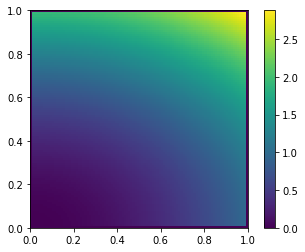

In [7]:
##RHS function
f = np.zeros([var.n_y,var.n_x])
for j in range(1, var.n_y-1):
    for i in range(1,var.n_x-1):
        f[j][i] = (i/var.n_x)**2 + 2*(j/var.n_x)**2

print('RHS function, f(x,y):')
plt.imshow(f, extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.show()

sigma:


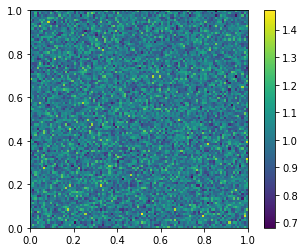

In [8]:
print('sigma:')
plt.imshow(var.sigma , extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.show()

## Functions

In [9]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [10]:
def opencl_mv(u):
    """
    Applies a standard centered finite difference scheme via openCL onto a vector 'u'
    
    """
    kernel = """
    __kernel void FD_kernel(__global double *u,
                            __global double *sigma,
                            __global double *Au
                            ){
    
        int gidcol = get_global_id(0);
        int gidrow = get_global_id(1);
        int gid = gidcol + n_x*gidrow;
        
        double h = 1.0/n_x;
                
        bool t = gid < n_x;
        bool b = gid > n_x*(n_y-1);
        bool l = gid % n_x == 0;
        bool r = (gid+1) % n_x == 0;
                
        if(t+b+l+r == 0){
            Au[gid] = -( 1.0/(h*h) )* 
                (0.5*(sigma[gid] + sigma[gid+1])*(u[gid+1] - u[gid])
                    - 0.5*(sigma[gid] + sigma[gid-1])*(u[gid] - u[gid-1])
                        + 0.5*(sigma[gid] + sigma[gid + n_x])*(u[gid + n_x] - u[gid])
                            - 0.5*(sigma[gid] + sigma[gid - n_x])*(u[gid] - u[gid - n_x]));
        }    
        
    }
    
    
    
    """
    queue.finish()

    sigma = np.array(var.sigma).astype('double')

    u = np.array(u).astype('double')
    Au = u.copy().astype('double')    

    ##mem flags
    mf = cl.mem_flags

    ##create buffers to read and write
    sigma_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=sigma)
    u_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=u)
    Au_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_WRITE, hostbuf = Au)

    ##build program
    prg = cl.Program(ctx, kernel)
    prg.build(options=['-D', 'n_x={0}'.format(var.n_x), '-D', 'n_y={0}'.format(var.n_y)])

    prg.FD_kernel(queue, (var.n_x,var.n_y), (1, 1), u_buffer, sigma_buffer, Au_buffer)

    queue.finish()

    cl.enqueue_copy(queue, Au, Au_buffer)

    queue.finish()

    return Au
    

In [11]:
#make LinearOperator for opencl function
opencl_LO = spla.LinearOperator((var.n_x*var.n_y,var.n_y*var.n_x), matvec = opencl_mv)

## Iterative Solvers

METHOD - gmres
Dimensions:  (100, 100)
Time (s):  5.050309181213379
Iterations:  1215


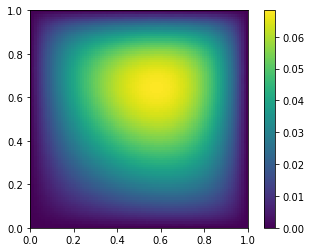

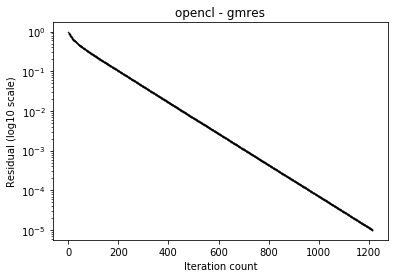

In [12]:
## gmres solver

with Timer() as t:
    opencl_gmres = spla.gmres(opencl_LO,f.ravel(), callback = counter_gmres)
    
opencl_gmres_time = t.interval
opencl_gmres_niter = counter_gmres.niter
opencl_gmres_resd = counter_gmres.resd[0:opencl_gmres_niter]

print('METHOD - gmres')
print('Dimensions: ', (var.n_x, var.n_y))
print('Time (s): ', opencl_gmres_time)
print('Iterations: ', opencl_gmres_niter)

##plot matrix map
plt.imshow(np.array(opencl_gmres[0]).reshape(var.n_y,var.n_x), extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.show()

##plot residual against iteration count with a log scale y-axis
fig, ax = plt.subplots()
ax.set(xlabel='Iteration count', ylabel='Residual (log10 scale)', title='opencl - gmres')
ax.semilogy(opencl_gmres_resd, 'k.', markersize = 1)

## reset counter_gmres and residual vector
counter_gmres.niter = 0
counter_gmres.resd.clear()

METHOD - bicgstab
Dimensions:  (100, 100)
Time (s):  1.1662116050720215
Iterations:  150


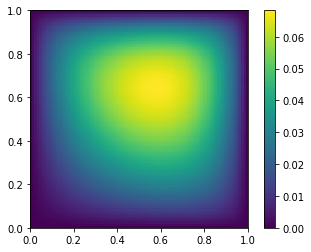

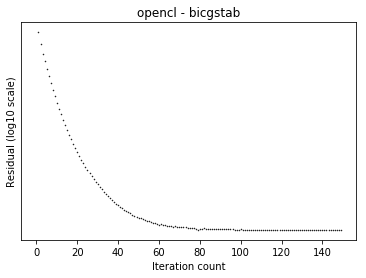

In [13]:
## bicgstab solver

with Timer() as t:
    opencl_bicgstab = spla.bicgstab(opencl_LO,f.ravel(), callback = counter_other)
    
opencl_bicgstab_time = t.interval
opencl_bicgstab_niter = counter_other.niter
opencl_bicgstab_resd = counter_other.resd[0:opencl_bicgstab_niter]

print('METHOD - bicgstab')
print('Dimensions: ', (var.n_x, var.n_y))
print('Time (s): ', opencl_bicgstab_time)
print('Iterations: ', opencl_bicgstab_niter)

##plot matrix map
plt.imshow(np.array(opencl_bicgstab[0]).reshape(var.n_y,var.n_x), extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.show()

##plot residual against iteration count with a log scale y-axis
fig, ax = plt.subplots()
ax.set(xlabel='Iteration count', ylabel='Residual (log10 scale)', title='opencl - bicgstab')
ax.semilogy(opencl_bicgstab_resd, 'k.', markersize = 1)

## reset counter_other and residual vector
counter_other.niter = 0
counter_other.resd.clear()

METHOD - minres
Dimensions:  (100, 100)
Time (s):  0.6272287368774414
Iterations:  149


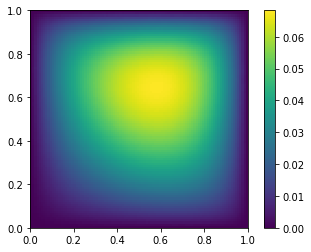

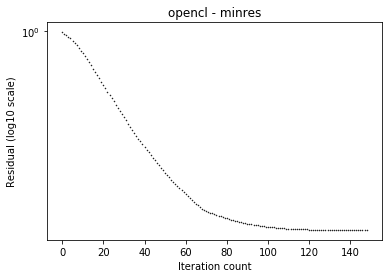

In [14]:
## minres solver

with Timer() as t:
    opencl_minres = spla.minres(opencl_LO,f.ravel(), callback = counter_other)
    
opencl_minres_time = t.interval
opencl_minres_niter = counter_other.niter
opencl_minres_resd = counter_other.resd[0:opencl_minres_niter]

print('METHOD - minres')
print('Dimensions: ', (var.n_x, var.n_y))
print('Time (s): ', opencl_minres_time)
print('Iterations: ', opencl_minres_niter)

##plot matrix map
plt.imshow(np.array(opencl_minres[0]).reshape(var.n_y,var.n_x), extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.show()

##plot residual against iteration count with a log scale y-axis
fig, ax = plt.subplots()
ax.set(xlabel='Iteration count', ylabel='Residual (log10 scale)', title='opencl - minres')
ax.semilogy(opencl_minres_resd, 'k.', markersize = 1)

## reset counter_other and residual vector
counter_other.niter = 0
counter_other.resd.clear()

METHOD - cg
Dimensions:  (100, 100)
Time (s):  0.9239499568939209
Iterations:  224


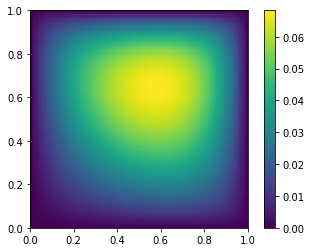

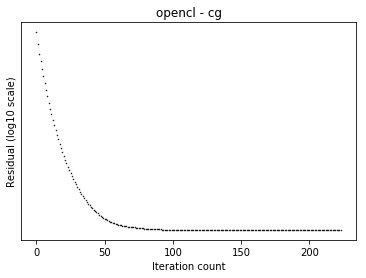

In [15]:
## cg solver

with Timer() as t:
    opencl_cg = spla.cg(opencl_LO,f.ravel(), callback = counter_other)
    
opencl_cg_time = t.interval
opencl_cg_niter = counter_other.niter
opencl_cg_resd = counter_other.resd[0:opencl_cg_niter]

print('METHOD - cg')
print('Dimensions: ', (var.n_x, var.n_y))
print('Time (s): ', opencl_cg_time)
print('Iterations: ', opencl_cg_niter)

##plot matrix map
plt.imshow(np.array(opencl_cg[0]).reshape(var.n_y,var.n_x), extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.show()

##plot residual against iteration count with a log scale y-axis
fig, ax = plt.subplots()
ax.set(xlabel='Iteration count', ylabel='Residual (log10 scale)', title='opencl - cg')
ax.semilogy(opencl_cg_resd, 'k.', markersize = 1)

## reset counter_other and residual vector
counter_other.niter = 0
counter_other.resd.clear()

## FEniCS

In [ ]:
#%matplotlib inline

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt

In [ ]:
mesh = UnitSquareMesh(40, 40)
V = FunctionSpace(mesh, "Lagrange", 1)

In [ ]:
# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS or x[1] > 1.0 - DOLFIN_EPS

In [ ]:
# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

In [ ]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
ff = Expression("x[0]*x[0] + 2* x[1]*x[1]", degree=2)
sigma = Expression("1 + x[0]*x[0] + x[1]*x[1]", degree=2)
a = inner(sigma*grad(u), grad(v))*dx
L = ff*v*dx

In [ ]:
# Compute solution
u = Function(V)
solve(a == L, u, bc)

In [ ]:
plot(u);